In [30]:
import numpy as np
from PIL import Image, ImageDraw
import torch
from torch.utils import data
from torchvision.transforms import transforms
import math
import random
import matplotlib.pyplot as plt

from utils.card_generator import get_face_pool, get_card_generator, get_true_mask
from utils import configs, generate_flat_bg

In [346]:
face_pool = get_face_pool()
original_mask = get_true_mask()
card_generator = get_card_generator(face_pool)
bg_generator = generate_flat_bg.get_bg_from_gi_generator()

In [622]:
original_img_shape = original_mask.shape

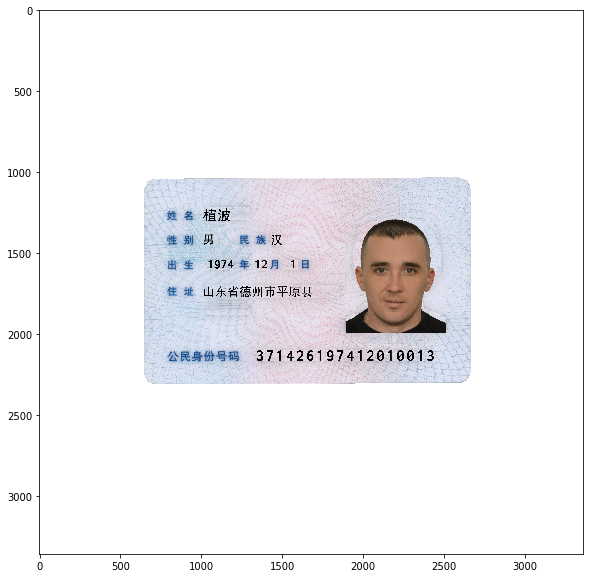

In [623]:
card = card_generator.__next__()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(card);

In [617]:
position = (649, 378 + 660)
size = (2017, 1270)

In [618]:
def get_orig_rectangle_coords(position, size) -> np.array:
    return np.array([
        [position[0], position[1]],
        [position[0] + size[0], position[1]],
        [position[0], position[1] + size[1]],
        [position[0] + size[0], position[1] + size[1]],
    ])

In [619]:
coords = get_orig_rectangle_coords(position, size)

In [620]:
def add_coords_to_img(img_arr: np.array, coords: np.array) -> Image:
    layers_map = {
        1: 'L',
        3: 'RGB',
        4: 'RGBA'
    }
    layer_count = img_arr.shape[2] if len(img_arr.shape) == 3 else 1
    image = Image.fromarray(img_arr.astype('uint8'), layers_map[layer_count])
    draw = ImageDraw.Draw(image)
    for point in coords:
        px = point.item(0)
        py = point.item(1)
        d = img_arr.shape[0] * 0.015
        draw.ellipse((px - d, py - d, px + d, py + d), fill="red")
    return image

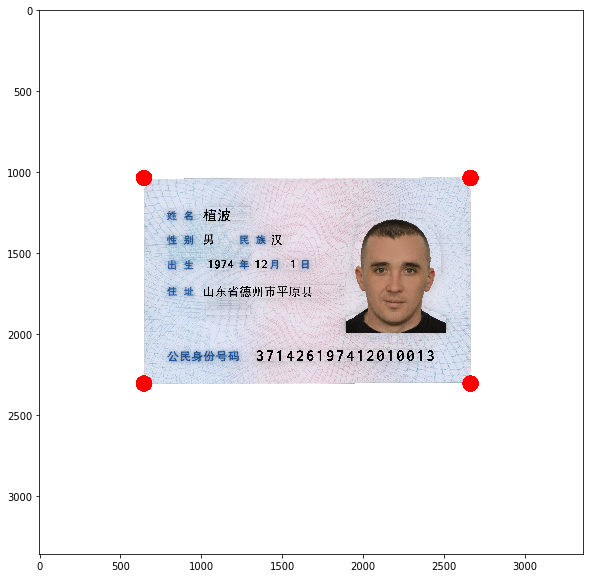

In [624]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(add_coords_to_img(card, get_orig_rectangle_coords(position, size)));

In [10]:
def show_mask_and_img_with_coords(mask, img, coords):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].set_axis_off()
    axes[0].imshow(mask);
    axes[1].set_axis_off()
    axes[1].imshow(add_coords_to_img(img, coords));

In [498]:
mask = original_mask
card = card_generator.__next__()
coords = get_orig_rectangle_coords(position, size)

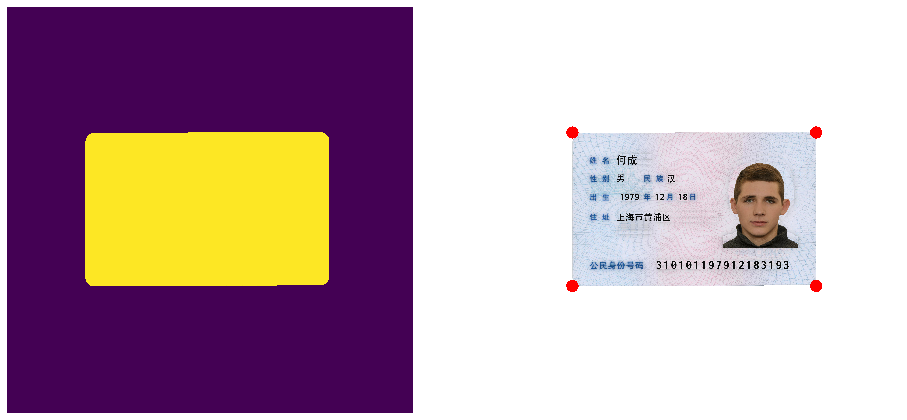

In [350]:
show_mask_and_img_with_coords(mask, card, coords)

# Let's rotate image

In [455]:
MAX_ANGLE = 45

theta = max(min(random.gauss(0, MAX_ANGLE / 3), MAX_ANGLE), -MAX_ANGLE)

In [477]:
theta = -30

In [465]:
theta

30

In [456]:
def rotate_coords(coords, angle, img_shape):
    a = angle / 180.0 * np.pi
    rotation_matrix = np.matrix(((np.cos(a), -np.sin(a)), (np.sin(a), np.cos(a))))
    x_center = img_shape[0]/2
    y_center = img_shape[1]/2
    coords_ = np.copy(coords)
    coords_[:, 0] = coords_[:, 0] - x_center
    coords_[:, 1] = coords_[:, 1] - y_center
    new_coords = coords_ @ rotation_matrix
    new_coords[:, 0] = new_coords[:, 0] + x_center
    new_coords[:, 1] = new_coords[:, 1] + y_center
    return new_coords

In [473]:
new_coords = rotate_coords(coords, theta, original_img_shape)

In [530]:
def rotate_image(img_arr: np.array, angle) -> np.array:
    layers_map = {
        1: 'L',
        3: 'RGB',
        4: 'RGBA'
    }
    layer_count = img_arr.shape[2] if len(img_arr.shape) == 3 else 1
    image = Image.fromarray(img_arr.astype('uint8'), layers_map[layer_count])
    image = image.rotate(angle, resample=Image.BILINEAR, expand=False)
    return np.array(image)

In [474]:
new_card = rotate_image(card, theta)
new_mask = rotate_image(mask, theta)

### make pipeline

In [468]:
def rotate_sample(mask, card, coords, theta):
    new_coords = rotate_coords(coords, theta, mask.shape)
    new_card = rotate_image(card, theta)
    new_mask = rotate_image(mask, theta)
    return new_mask, new_card, new_coords

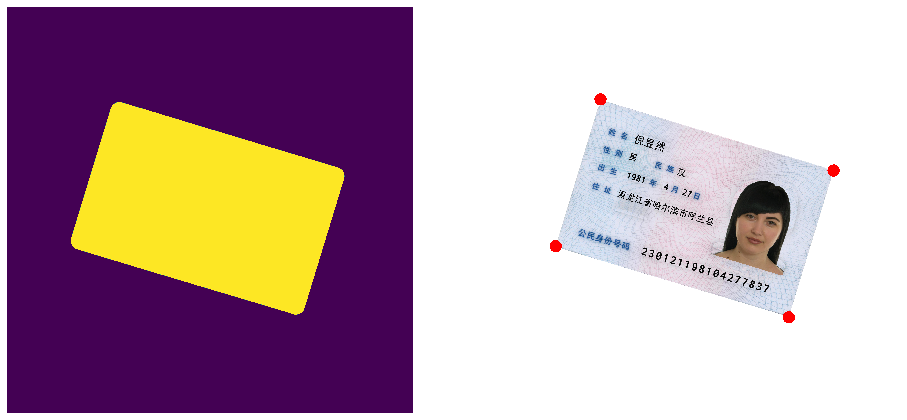

In [514]:
theta = max(min(random.gauss(0, MAX_ANGLE / 3), MAX_ANGLE), -MAX_ANGLE)

new_mask, new_card, new_coords = rotate_sample(mask, card, coords, theta)

show_mask_and_img_with_coords(new_mask, new_card, new_coords)

# Let's resize image

In [371]:
max_ratio = mask.shape[0] / math.sqrt(size[0]**2 + size[1]**2)
min_ratio = 0.8

ratio = random.uniform(min_ratio, max_ratio)

In [372]:
ratio

0.8255127154770926

In [636]:
def resize_coords(coords, ratio, img_shape, with_canvas: bool = False):
    x_center = img_shape[0]/2
    y_center = img_shape[1]/2
    coords_ = np.copy(coords)
    coords_[:, 0] = coords_[:, 0] - x_center
    coords_[:, 1] = coords_[:, 1] - y_center
    new_coords = np.multiply(coords_, ratio)
    if with_canvas:
        x_center *= ratio
        y_center *= ratio
    new_coords[:, 0] = new_coords[:, 0] + x_center
    new_coords[:, 1] = new_coords[:, 1] + y_center
    return new_coords

In [637]:
new_coords = resize_coords(coords, ratio, original_img_shape)

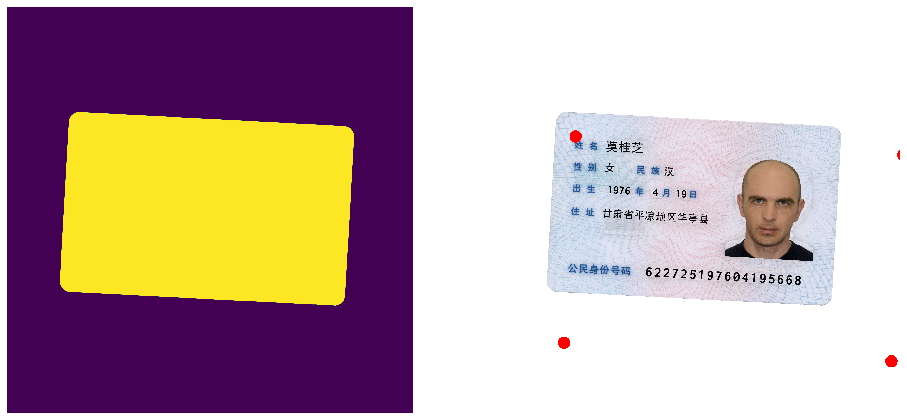

In [638]:
show_mask_and_img_with_coords(mask, card, new_coords)

In [412]:
def resize_image(img_arr: np.array, ratio) -> np.array:
    layers_map = {
        1: 'L',
        3: 'RGB',
        4: 'RGBA'
    }
    layer_count = img_arr.shape[2] if len(img_arr.shape) == 3 else 1
    image = Image.fromarray(img_arr.astype('uint8'), layers_map[layer_count])
    orig_height = image.height
    orig_width = image.width
    new_height = int(image.height * ratio)
    new_width = int(image.width * ratio)
    image = image.resize((new_width, new_height))
    if new_width > orig_width:
        left = int((new_width - orig_width) / 2)
        top = int((new_height - orig_height) / 2)
        right = left + orig_width
        bottom = top + orig_height
        image = image.crop((left, top, right, bottom))
        return np.array(image)
    else:
        left = int((orig_width - new_width) / 2)
        top = int((orig_height - new_height) / 2)
        new_image = Image.new(layers_map[layer_count], (orig_width, orig_height))
        new_image.paste(image, (left, top))
        return np.array(new_image)

In [415]:
new_card = resize_image(card, ratio)
new_mask = resize_image(mask, ratio)

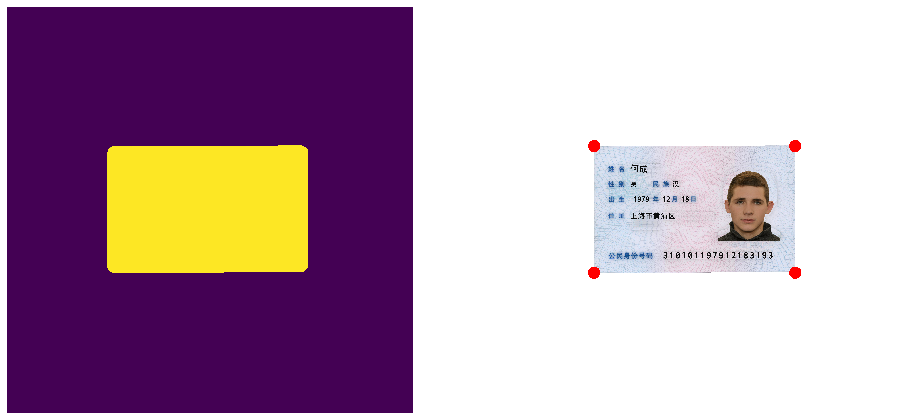

In [417]:
show_mask_and_img_with_coords(new_mask, new_card, new_coords)

### make pipeline

In [51]:
def resize_sample(mask, card, coords, ratio):
    new_coords = resize_coords(coords, ratio, mask.shape)
    new_card = resize_image(card, ratio)
    new_mask = resize_image(mask, ratio)
    return new_mask, new_card, new_coords

In [54]:
mask, card, coords = resize_sample(mask, card, coords, ratio)

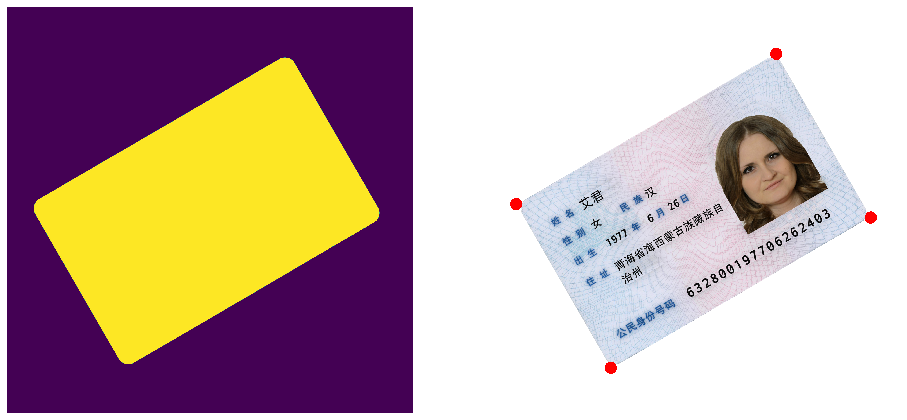

In [55]:
show_mask_and_img_with_coords(mask, card, coords)

# Let's shift image

In [56]:
mask.shape

(3360, 3360)

In [67]:
min_coords = np.floor(np.amin(coords, axis=0))

In [68]:
left_gap = min_coords

In [69]:
max_coords = np.ceil(np.amax(coords, axis=0))

In [70]:
right_gap = np.array(mask.shape) - max_coords

In [71]:
max_shift_x = min(left_gap.item(0), right_gap.item(0)) - 20

In [73]:
max_shift_y = min(left_gap.item(1), right_gap.item(1)) - 20

In [75]:
shift_x = random.gauss(0, max_shift_x / 3)

In [76]:
shift_y = random.gauss(0, max_shift_y / 3)

In [77]:
shift_x, shift_y

(-59.317910415083205, -173.95044741093787)

In [149]:
def get_shift(coords, original_shape):
    left_gap = np.floor(np.amin(coords, axis=0))
    right_gap = np.array(original_shape) - np.ceil(np.amax(coords, axis=0))
    max_shift_x = min(left_gap.item(0), right_gap.item(0)) - 20
    max_shift_y = min(left_gap.item(1), right_gap.item(1)) - 20
    shift_x = min(random.gauss(0, max_shift_x / 3), max_shift_x)
    shift_y = min(random.gauss(0, max_shift_y / 3), max_shift_y)
    return shift_x, shift_y

In [174]:
shift_x, shift_y = get_shift(coords, mask.shape)

In [175]:
shift_x, shift_y

(-11.634189689588792, 216.23703825209276)

In [155]:
def shift_coords(coords, shift_x, shift_y):
    new_coords = np.copy(coords)
    new_coords[:, 0] = new_coords[:, 0] + shift_x
    new_coords[:, 1] = new_coords[:, 1] + shift_y
    return new_coords

In [176]:
new_coords = shift_coords(coords, shift_x, shift_y)

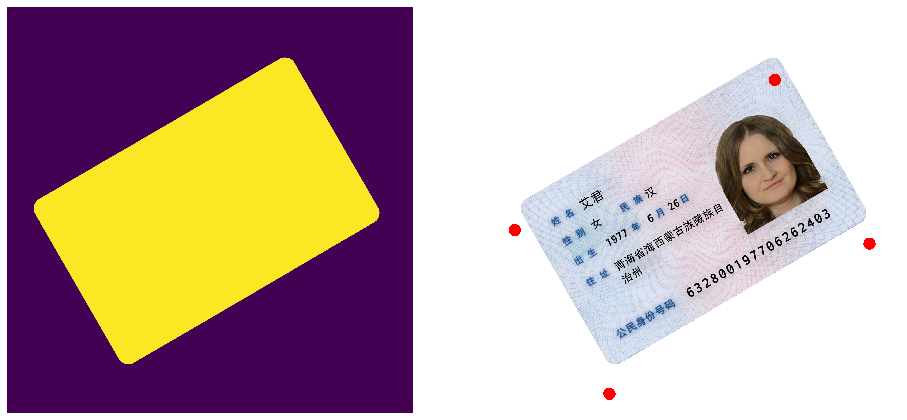

In [177]:
show_mask_and_img_with_coords(mask, card, new_coords)

In [194]:
def shift_image(img_arr: np.array, shift_x, shift_y) -> np.array:
    layers_map = {
        1: 'L',
        3: 'RGB',
        4: 'RGBA'
    }
    layer_count = img_arr.shape[2] if len(img_arr.shape) == 3 else 1
    image = Image.fromarray(img_arr.astype('uint8'), layers_map[layer_count])
    image = image.transform(image.size, Image.AFFINE, (1, 0, -shift_x, 0, 1, -shift_y))
    return np.array(image)

In [197]:
new_card = shift_image(card, shift_x, shift_y)
new_mask = shift_image(mask, shift_x, shift_y)

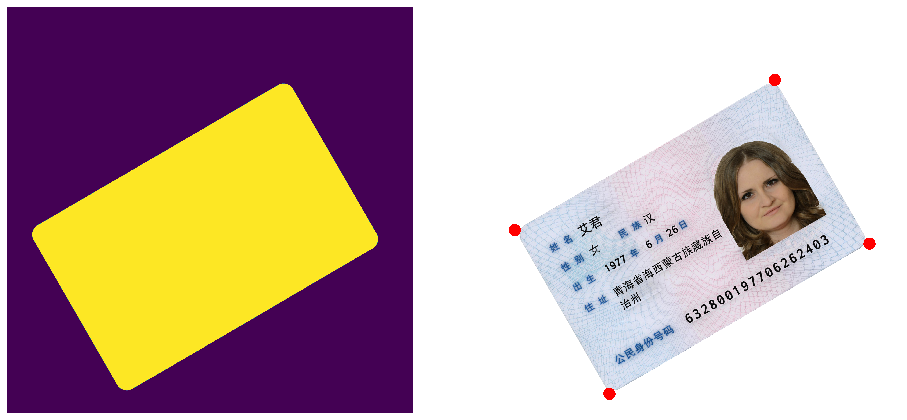

In [198]:
show_mask_and_img_with_coords(new_mask, new_card, new_coords)

### make pipeline

In [199]:
def shift_sample(mask, card, coords, shift_x, shift_y):
    new_coords = shift_coords(coords, shift_x, shift_y)
    new_card = shift_image(card, shift_x, shift_y)
    new_mask = shift_image(mask, shift_x, shift_y)
    return new_mask, new_card, new_coords

In [200]:
mask, card, coords = shift_sample(mask, card, coords, shift_x, shift_y)

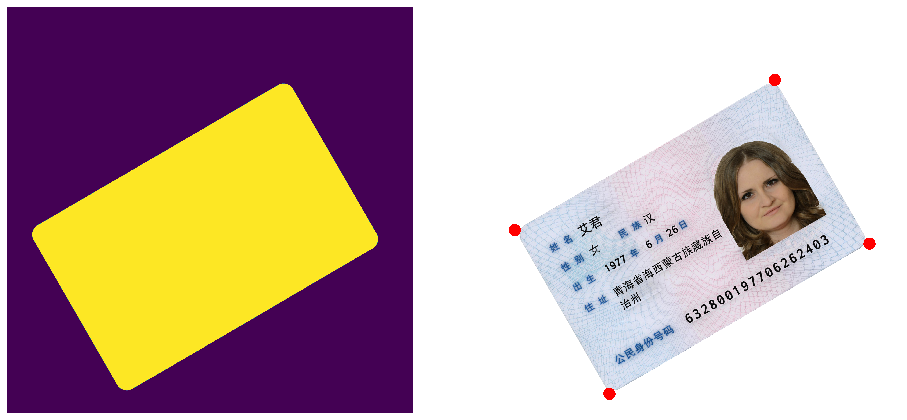

In [201]:
show_mask_and_img_with_coords(mask, card, coords)

# Get all together

In [639]:
CARD_POSITION = (649, 378 + 660)
CARD_SIZE = (2017, 1270)

In [640]:
mask = original_mask
card = card_generator.__next__()
coords = get_orig_rectangle_coords(CARD_POSITION, CARD_SIZE)

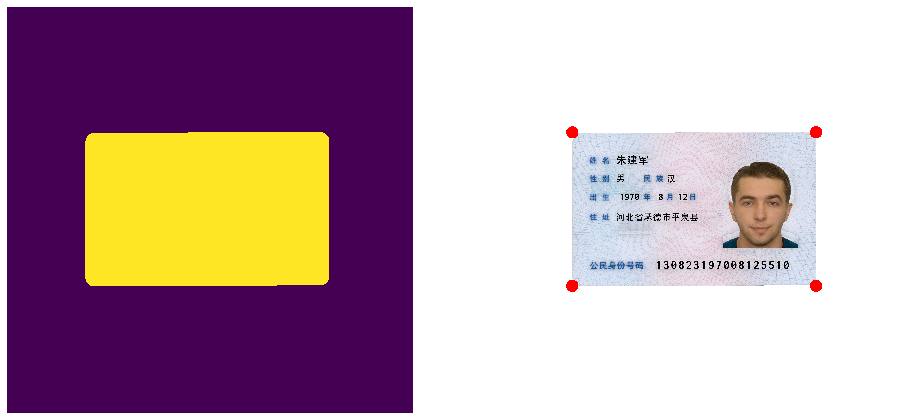

In [641]:
show_mask_and_img_with_coords(mask, card, coords)

In [642]:
MAX_ANGLE = 45
theta = max(min(random.gauss(0, MAX_ANGLE / 3), MAX_ANGLE), -MAX_ANGLE)
mask, card, coords = rotate_sample(mask, card, coords, theta)

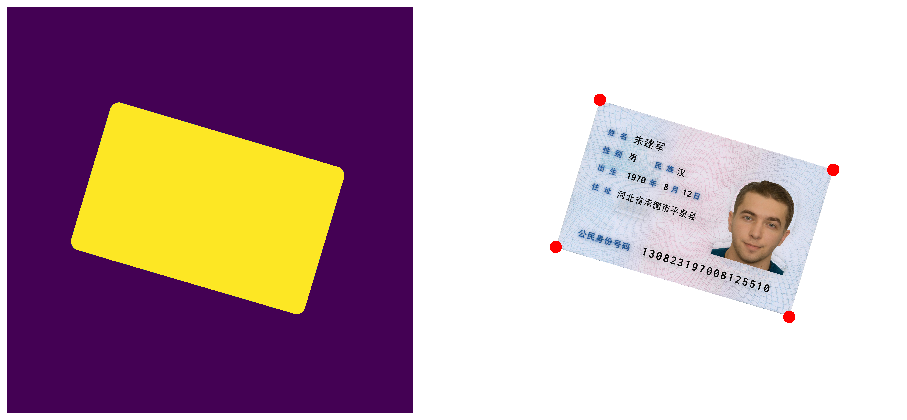

In [643]:
show_mask_and_img_with_coords(mask, card, coords)

In [644]:
max_ratio = mask.shape[0] / math.sqrt(CARD_SIZE[0]**2 + CARD_SIZE[1]**2)
min_ratio = 0.8
ratio = random.uniform(min_ratio, max_ratio)
mask, card, coords = resize_sample(mask, card, coords, ratio)

In [645]:
ratio

1.183936496945881

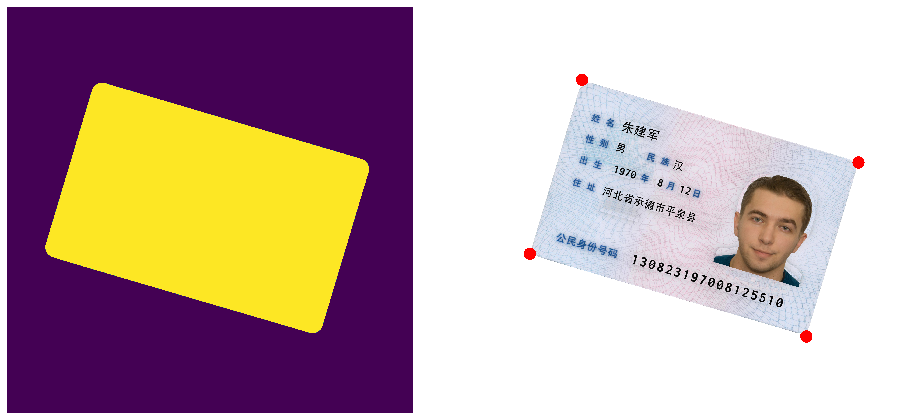

In [646]:
show_mask_and_img_with_coords(mask, card, coords)

In [647]:
shift_x, shift_y = get_shift(coords, mask.shape)
mask, card, coords = shift_sample(mask, card, coords, shift_x, shift_y)

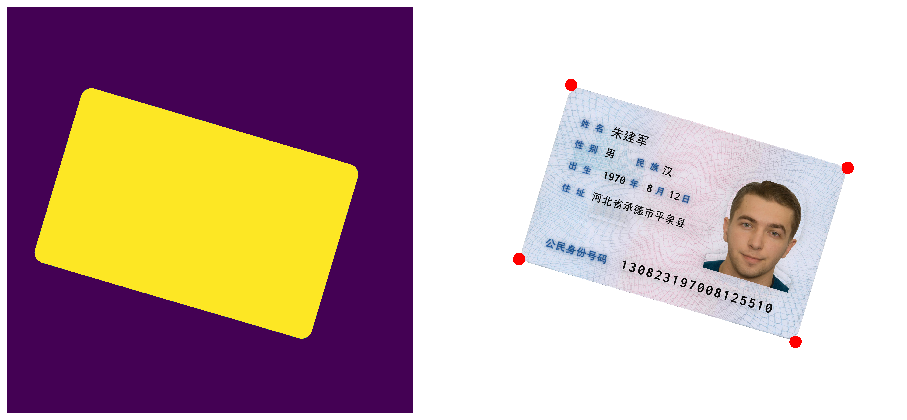

In [648]:
show_mask_and_img_with_coords(mask, card, coords)

In [649]:
CARD_POSITION = (649, 378 + 660)
CARD_SIZE = (2017, 1270)
MAX_ANGLE = 45
MIN_RATIO = 0.7

In [650]:
def get_sample():
    mask = original_mask
    card = card_generator.__next__()
    coords = get_orig_rectangle_coords(CARD_POSITION, CARD_SIZE)

    theta = max(min(random.gauss(0, MAX_ANGLE / 3), MAX_ANGLE), -MAX_ANGLE)
    mask, card, coords = rotate_sample(mask, card, coords, theta)
    
    max_ratio = mask.shape[0] / math.sqrt(CARD_SIZE[0]**2 + CARD_SIZE[1]**2)
    ratio = random.uniform(MIN_RATIO, max_ratio)
    mask, card, coords = resize_sample(mask, card, coords, ratio)
    
    shift_x, shift_y = get_shift(coords, mask.shape)
    mask, card, coords = shift_sample(mask, card, coords, shift_x, shift_y)
    
    return mask, card, coords

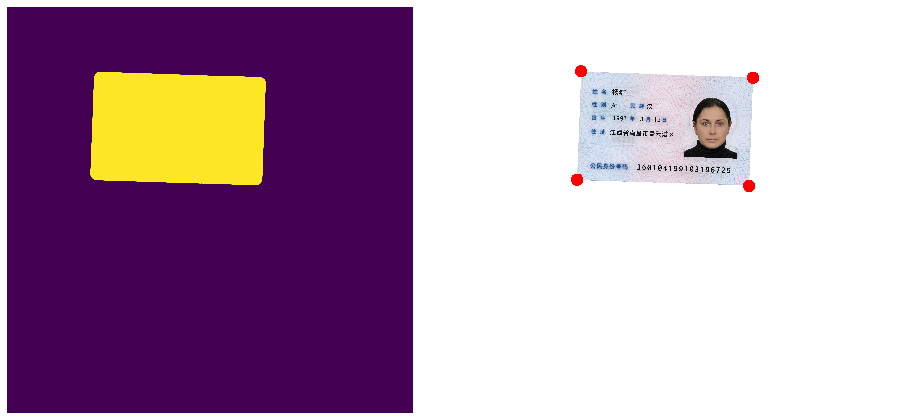

In [651]:
mask, card, coords = get_sample()
show_mask_and_img_with_coords(mask, card, coords)

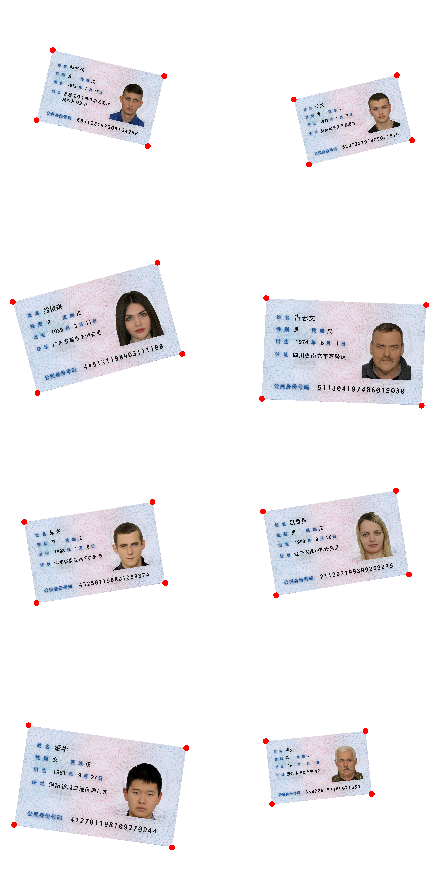

In [652]:
rows = 4
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
for i in range(rows):
    for j in range(cols):
        _, card, coords = get_sample()
        axes[i, j].set_axis_off()
        axes[i, j].imshow(add_coords_to_img(card, coords));

# Get GI background

In [566]:
from utils.helpers import resize_to_256
import os
import imageio

In [569]:
def load_gi_bg(path, filename):
    file_path = os.path.join(path, filename)
    img = imageio.imread(file_path, pilmode="RGB")
    return np.array(img, dtype=np.uint8)

In [562]:
path = './data/images'
filenames = os.listdir(path)

In [563]:
random.choice(filenames)

'36.065f0f_68fe12149fe2496f93715b89f1ec8359~mv2.jpg'

In [567]:
def get_gi_bg(path:str = './data/images'):
    filenames = os.listdir(path)
    while True:
        filename = random.choice(filenames)
        try:
            arr = load_gi_bg(path, filename)
        except:
            continue
        else:
            return resize_to_256(arr)

In [577]:
bg_sample = get_gi_bg()

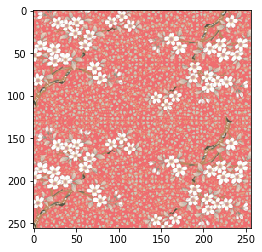

In [578]:
plt.imshow(bg_sample);

# Resize sample to 256

In [581]:
new_card = resize_to_256(card)
new_mask = resize_to_256(mask)

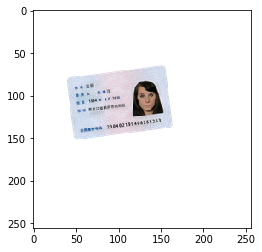

In [583]:
plt.imshow(new_card);

In [594]:
coords

array([[ 514.82964405, 1042.30602484],
       [2035.0921265 ,  851.73565128],
       [ 634.82189711, 1999.53624433],
       [2155.08437956, 1808.96587076]])

In [595]:
ratio = 256.0 / mask.shape[0]
new_coords = resize_coords(coords, ratio, mask.shape)

In [596]:
ratio

0.0761904761904762

In [597]:
new_coords

array([[ 39.22511574,  79.41379237],
       [155.05463821,  64.89414486],
       [ 48.36738264, 152.34561862],
       [164.19690511, 137.82597111]])

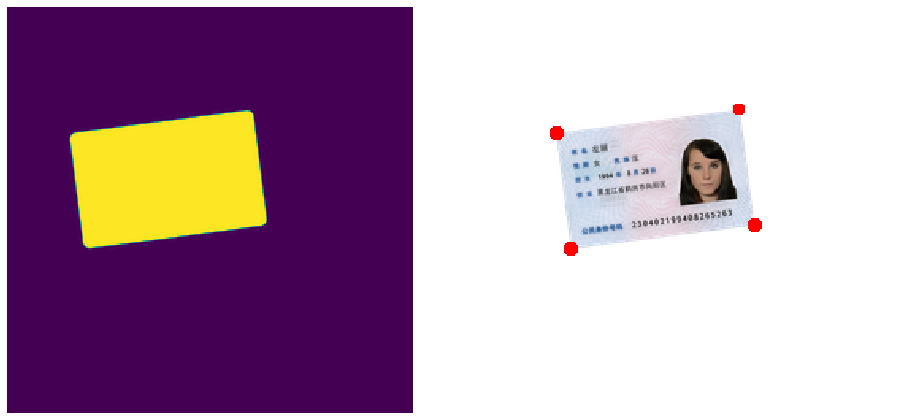

In [600]:
show_mask_and_img_with_coords(new_mask, new_card, new_coords)

In [653]:
def sample_to_256(mask, card, coords):
    ratio = 256.0 / mask.shape[0]
    new_coords = resize_coords(coords, ratio, mask.shape, with_canvas=True)
    new_card = resize_to_256(card)
    new_mask = resize_to_256(mask)
    return new_mask, new_card, new_coords

In [602]:
mask, card, coords = sample_to_256(mask, card, coords)

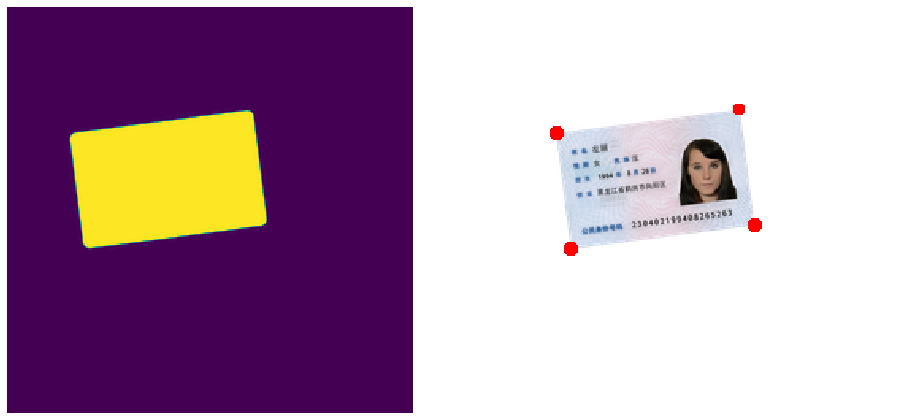

In [603]:
show_mask_and_img_with_coords(mask, card, coords)

# Composite with backround

In [604]:
def merge_by_mask(background, foreground, mask):
    w, h, chanells = background.shape
    merg_arr = np.array(background, dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            if mask[i][j] > 100:
                for c in range(chanells):
                    merg_arr[i][j][c] = foreground[i][j][c]
    return merg_arr

In [605]:
gi_bg = get_gi_bg()
card_with_bg = merge_by_mask(gi_bg, card, mask)

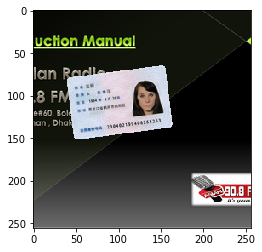

In [606]:
plt.imshow(card_with_bg);

In [609]:
mask.shape, card_with_bg.shape

((256, 256), (256, 256, 3))

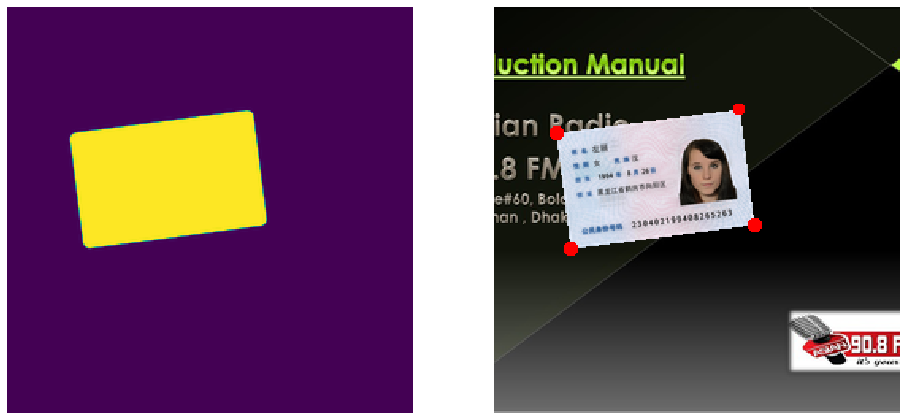

In [611]:
show_mask_and_img_with_coords(mask, card_with_bg, coords)

CPU times: user 50.5 s, sys: 276 ms, total: 50.8 s
Wall time: 51.1 s


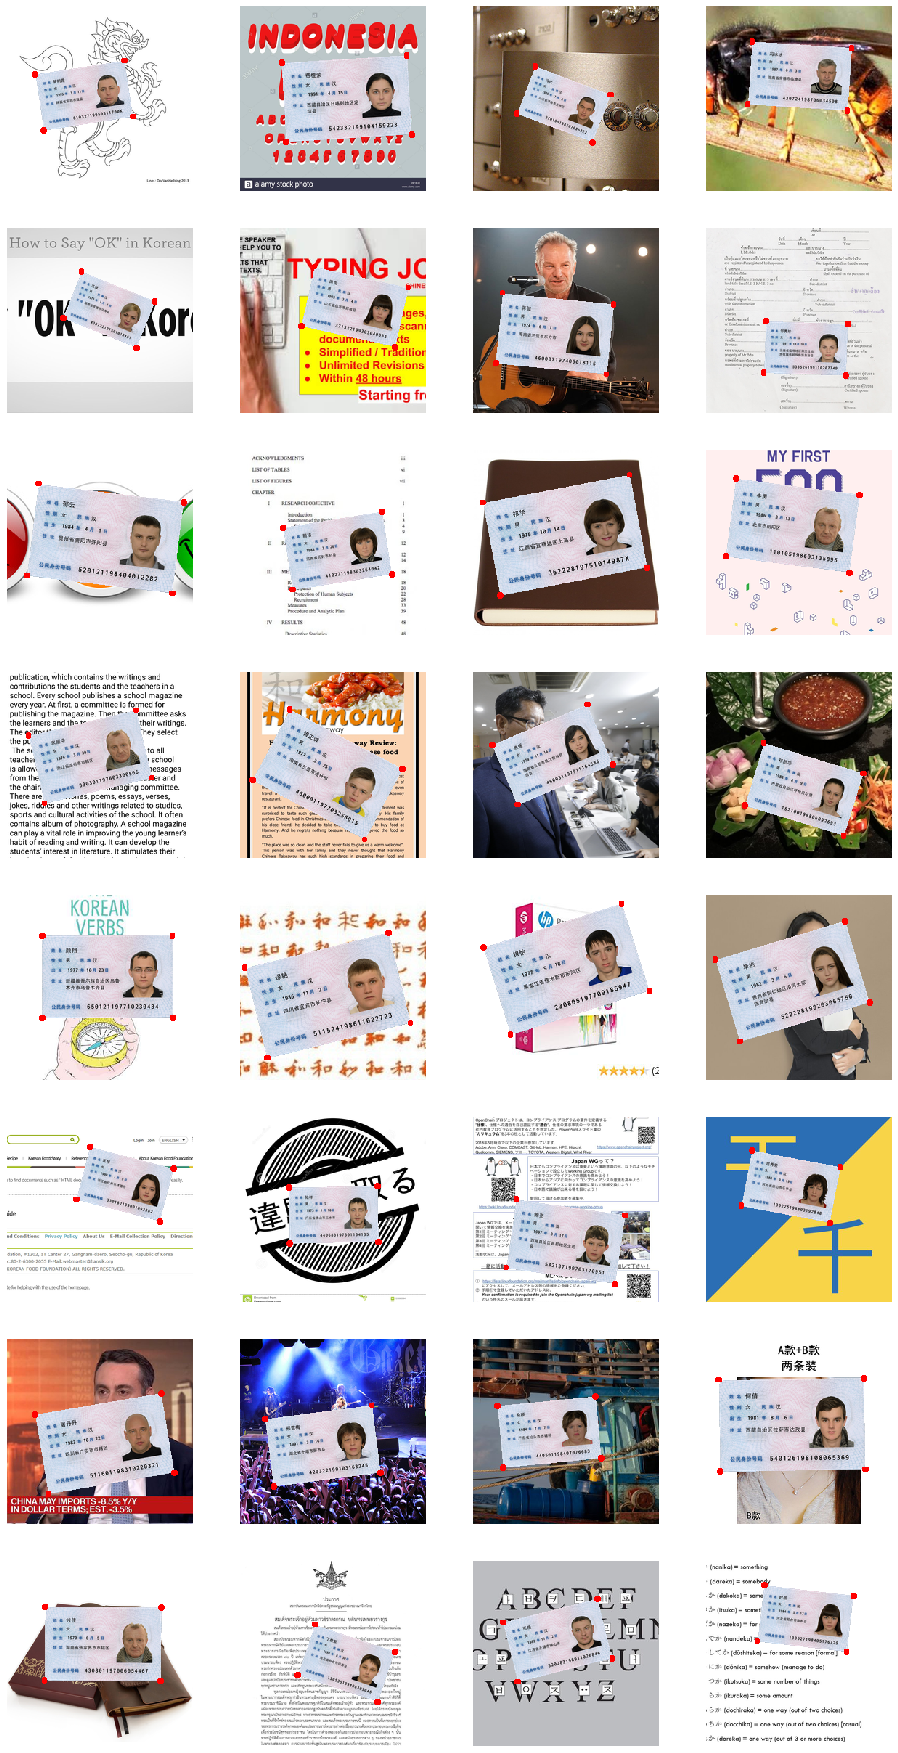

In [655]:
%%time
rows = 8
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
for i in range(rows):
    for j in range(cols):
        mask, card, coords = None, None, None
        mask, card, coords = get_sample()
        mask, card, coords = sample_to_256(mask, card, coords)
        gi_bg = get_gi_bg()
        card_with_bg = merge_by_mask(gi_bg, card, mask)
        axes[i, j].set_axis_off()
        axes[i, j].imshow(add_coords_to_img(card_with_bg, coords));

# Make optimization

In [659]:
def get_sample_256():
    mask = original_mask
    card = card_generator.__next__()
    coords = get_orig_rectangle_coords(CARD_POSITION, CARD_SIZE)
    
    mask, card, coords = sample_to_256(mask, card, coords)

    theta = max(min(random.gauss(0, MAX_ANGLE / 3), MAX_ANGLE), -MAX_ANGLE)
    mask, card, coords = rotate_sample(mask, card, coords, theta)
    
    canvas_ratio = 256.0 / original_mask.shape[0]
    CARD_SIZE_ = (CARD_SIZE[0] * canvas_ratio, CARD_SIZE[1] * canvas_ratio)
    
    max_ratio = mask.shape[0] / math.sqrt(CARD_SIZE_[0]**2 + CARD_SIZE_[1]**2)
    ratio = random.uniform(MIN_RATIO, max_ratio)
    mask, card, coords = resize_sample(mask, card, coords, ratio)
    
    shift_x, shift_y = get_shift(coords, mask.shape)
    mask, card, coords = shift_sample(mask, card, coords, shift_x, shift_y)
    
    return mask, card, coords

CPU times: user 14.3 s, sys: 207 ms, total: 14.5 s
Wall time: 14.8 s


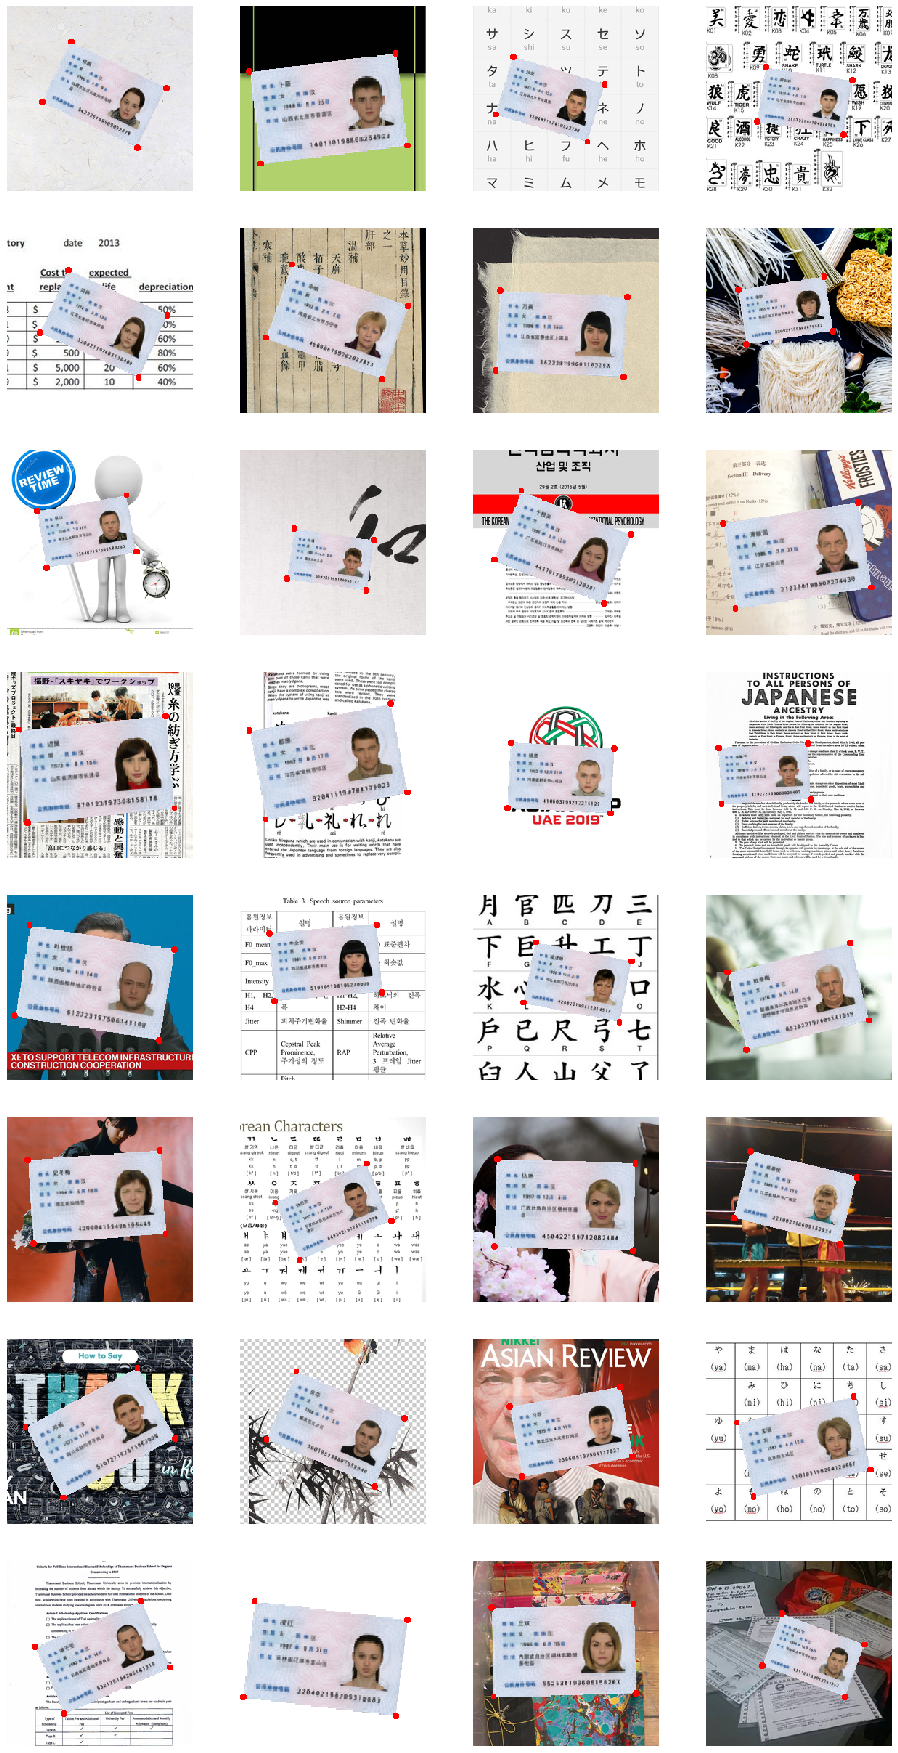

In [660]:
%%time
rows = 8
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
for i in range(rows):
    for j in range(cols):
        mask, card, coords = None, None, None
        mask, card, coords = get_sample_256()
        gi_bg = get_gi_bg()
        card_with_bg = merge_by_mask(gi_bg, card, mask)
        axes[i, j].set_axis_off()
        axes[i, j].imshow(add_coords_to_img(card_with_bg, coords));